### Setup

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100) 

from os import path
import pickle

import missingno as msno
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, cross_val_predict

from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Import

In [2]:
f = 'loan_clean.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'rb') as file:
    data = pickle.load(file)

In [3]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default,default_harsh,had_delinq,had_major_derog,had_record,annual_inc_merged,dti_merged,rev_util_custom,rev_lim_custom,tot_cur_bal_filled,tot_cur_bal_med,had_collections,verification_status_merged,earliest_cr_line_td
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077501,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,credit_card,860xx,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0,0,0,0,0,24000.0,27.65,83.7,16305.854241,15008.0,15008.0,0,Verified,-9830
1077430,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,car,309xx,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1,1,0,0,0,30000.0,1.00,9.4,17946.808511,24713.0,24713.0,0,Source Verified,-4627
1077175,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,small_business,606xx,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0,0,0,0,0,12252.0,8.72,98.5,3001.015228,15008.0,15008.0,0,Not Verified,-3682
1076863,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,other,917xx,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0,0,1,0,0,49200.0,20.00,21.0,26657.142857,49042.0,49042.0,0,Source Verified,-5782
1075269,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,36000.0,Source Verified,2011-12-01,Fully Paid,n,wedding,852xx,AZ,11.20,0.0,2004-11-01,3.0,9.0,0.0,7963.0,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,161.03,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0,0,0,0,0,36000.0,11.20,28.3,28137.809187,30048.0,30048.0,0,Source Verified,-2586


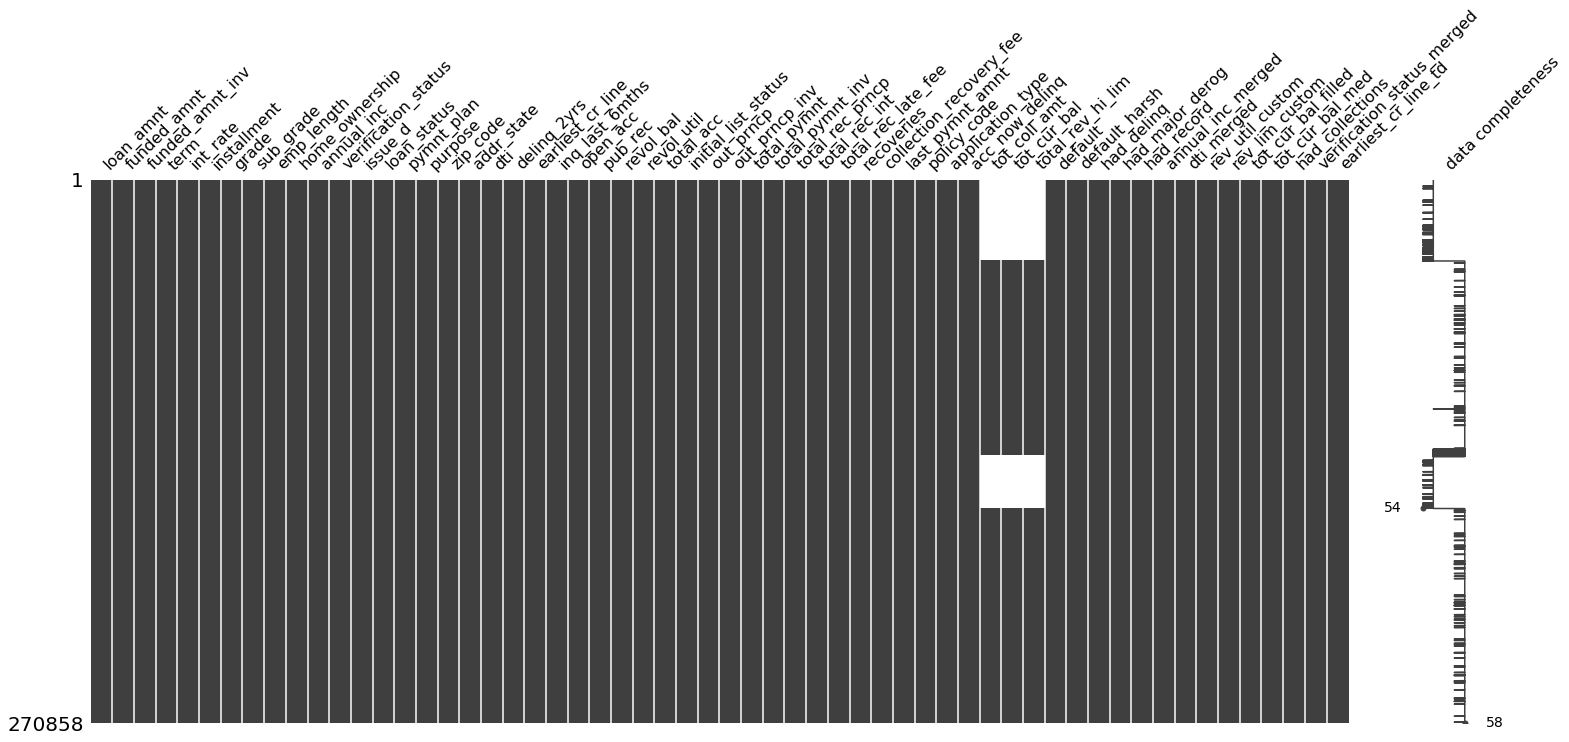

In [4]:
msno.matrix(data, labels=True)

In [5]:
data.isnull().sum()

loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_length                        0
home_ownership                    0
annual_inc                        0
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
purpose                           0
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                       0
earliest_cr_line                  0
inq_last_6mths                    0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                      222
total_acc                         0
initial_list_status         

### Target Variable

For this classification problem, our goal is to identify loans that will default. The original column capturing this information is <i>loan_status</i>, however these values extend beyond simple default/paid, so this has to be simplified into a binary true/false value.

During initial data cleaning two new column were created: one identifying basic default loans (status of Default of Charged Off), and one which was more unforgiving in classifying defaults by including any late loans as well. For the purpose of this MVP analysis, we will keep things simple and focus on the basic definition of a defualt loan.

As for the other statuses, all current loans need to be removed from the dataset. Analysis can only be conducted on loans that have completed their term or been written off, since otherwise ther is no way of knowing the terminal status of paid / default. The basic current / active loans were already removed during data cleaning, but we will also need to drop the 'late' loans since we are opting to not identify these as default.

In [3]:
# Extract late loans
late_mask = data['loan_status'].str.contains('Late')
data_late = data[late_mask]

In [4]:
# Save late loan data in separate file
f = 'loan_late.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'wb') as file:
    pickle.dump(data_late, file)

In [5]:
# Remove late status entries
data = data[~late_mask].copy()

In [6]:
data['loan_status'].value_counts()

Fully Paid     209685
Charged Off     46006
Default          1219
Name: loan_status, dtype: int64

In [7]:
data['default'].value_counts()

0    209685
1     47225
Name: default, dtype: int64

In [8]:
# Drop alternative default status column used for including late status loans as default
data.drop('default_harsh', axis=1, inplace=True)

In [9]:
target = data['default']

### Feature Selection

For the purpose of this MVP analysis and setting some basic benchmarks for comparison with more in-depth models, feature selection will be limited to a few key variables, which based off the data analysis thus far (see EDA) one would anticipate to influence whether a loan defaults:

In [10]:
num_attr = ['annual_inc_merged', 'int_rate', 'dti_merged', 'rev_util_custom', 'rev_lim_custom', 'tot_cur_bal_filled', 'loan_amnt', 'installment',
            'inq_last_6mths', 'earliest_cr_line_td', 'total_acc', 'open_acc', 'delinq_2yrs', 'pub_rec', 'collection_recovery_fee',
            'acc_now_delinq', 'had_delinq', 'had_major_derog', 'had_record', 'had_collections']

cat_attr = ['grade','sub_grade', 'emp_length', 'purpose', 'home_ownership', 'verification_status_merged', 'application_type', 'term']

Note that any columns containing payment summaries have been deliberately omitted. The reasoning for this is that these values can only be known after a loan has completed its term. Consequently, these values do not reflect he loans properties at the time of issuing and/or initial investment, which is what our analysis is interested in.

Preparing the basic pipelines to set up the new dataframe:

In [11]:
# Class for selecting attributes from a dataframe, for use in pipelines

class DataFrame_Selector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [12]:
class DataFrame_DummyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        dummies = pd.get_dummies(X[self.attribute_names])
        return dummies.values

In [13]:
num_pipeline = Pipeline([('selector', DataFrame_Selector(num_attr)),
                         ('std_scaler', StandardScaler())])

cat_pipeline = Pipeline([('selector', DataFrame_DummyEncoder(cat_attr))])

prep_pipeline = FeatureUnion(transformer_list=[('num_pipeline', num_pipeline),
                                               ('cat_pipeline', cat_pipeline)])

In [14]:
data_prepared = prep_pipeline.fit_transform(data)

In [15]:
data_prepared.shape

(256910, 101)

### Modeling

In [36]:
# Initialize list/dict for models
models = []

In [16]:
# Function to plot PR curve
def plot_pr_curve(model, X, y, label=None, cv=3, n_jobs=-1):
    if hasattr(model, 'decision_function'):
        y_scores = cross_val_predict(model, X, y, cv=cv, method='decision_function', n_jobs=n_jobs)[:,1]
    else:
        y_scores = cross_val_predict(model, X, y, cv=cv, method='predict_proba', n_jobs=n_jobs)[:,1]
    
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    
    fig, axs = plt.subplots(1,2,figsize=(15,7))

    axs[0].plot(thresholds, precisions[:-1], 'b--', label='Precision')
    axs[0].plot(thresholds, recalls[:-1], 'g-', label='Recall')
    x_min = max(thresholds[(len(recalls) - np.argmax(recalls[::-1][:-1]) -1)]*1.1, min(thresholds))
    x_max = min(thresholds[np.argmax(precisions[:-1])]*1.1, max(thresholds))
    axs[0].set_xlim(x_min, x_max)
    axs[0].set_xlabel('Decision Threshold')
    axs[0].set_ylabel('Precision / Recall')
    axs[0].legend()

    axs[1].plot(recalls[:-1], precisions[:-1], 'r-')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')

    plt.suptitle('Precision/Recall Curve{}'.format(': ' + str(label) if label is not None else ''))

    plt.show()
    
    return precisions, recalls, thresholds

In [17]:
def classifier_summary(y_actual, y_pred, print_results=True): 
    
    f1 = f1_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    
    conf_mat = confusion_matrix(y_actual, y_pred)
    
    specificity = conf_mat[0,0] / (conf_mat[:,0].sum())
    fallout = 1 - specificity
    
    df_cmat = pd.DataFrame(conf_mat).rename(index={0:'Actual Negative', 1:'Actual Positive'},
                                  columns={0:'Predicted Negative', 1:'Predicted Positive'})
    
    df_scores = pd.DataFrame([{'Rate': 'f1', 'Score': f1},
                              {'Rate': 'Recall', 'Score': recall},
                              {'Rate': 'Precision', 'Score': precision},
                              {'Rate': 'Specificity', 'Score': specificity},
                              {'Rate': 'Fallout', 'Score': fallout}]).set_index('Rate')
    
    if print_results:
        print('Confusion Matrix:')
        print(df_cmat)
        print(20*'-')
        print('Accuracy Scores:')
        print(df_scores)
   
    return df_cmat, df_scores

##### Train/Test Split

In [20]:
X = data_prepared
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Note that for the purposes of this this MVP analysis, we will not be splitting data further into train/validation sets, and simply be using the test set for evaluation. We are simply trying to get a rough benchmark for various models so optimization will be limited so there is need for concern of overfitting/adjusting for the test set.

##### Logistic Regression


Basic model, no tuning:

In [22]:
logreg = LogisticRegression()

In [23]:
logreg_cvs = cross_val_score(estimator=logreg, X=X_train, y=y_train, cv=10, scoring='f1', n_jobs=-1)
logreg_cvs.mean()

0.5783686745105322

In [24]:
logreg.fit(X_train, y_train);

In [28]:
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

In [31]:
train_score = f1_score(y_train, y_train_pred)
train_score

0.51486857591212243

In [38]:
confusion_matrix(y_train, y_train_pred)

array([[167672,     50],
       [ 24682,  13124]], dtype=int64)

In [41]:
recall_score(y_train, y_train_pred)

0.34714066550283024

Low recall - only 34% of defaulted loans accurately identified in the train set.

In [33]:
test_score = f1_score(y_test, y_test_pred)
test_score

0.50849600885165569

In [39]:
confusion_matrix(y_test, y_test_pred)

array([[41946,    17],
       [ 6202,  3217]], dtype=int64)

In [42]:
recall_score(y_test, y_test_pred)

0.34154368828962733

Again, low recall with similar 34% of defaulted loans correctly identified.

In [37]:
# Add model to list
model = {'model_name': 'LogReg (Basic)',
         'model_type':'LogisticRegression',
         'model': logreg,
         'train_score': train_score,
         'test_score': test_score}

models.append(model)

Improving recall is the priority given the business problem/context. The financial risks/costs with failing to identify a loan that will default greatly outweigh those of falsely classifying a good loan as a will-default.

Will attempt to do some basic improvements via hyperparameter tuning:

In [84]:
logreg = LogisticRegression(n_jobs=-1) # sag due to large dataset

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 100],
              'class_weight': ['balanced', None]}

logreg_gs = GridSearchCV(estimator=logreg,
                  param_grid = param_grid,
                  scoring='f1',
                  cv=3,
                  n_jobs=-1)

logreg_gs.fit(X_train, y_train);

C:\Users\David\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


In [85]:
logreg_gs.best_score_

0.59345711335025753

In [86]:
logreg_gs.best_params_

{'C': 100, 'class_weight': 'balanced'}

In [52]:
logreg_best = logreg_gs.best_estimator_

Repeat scoring for tuned model:

In [376]:
y_train_pred = logreg_best.predict(X_train)
y_test_pred = logreg_best.predict(X_test)

In [377]:
cmat_train, scores_train = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              134813               32909
Actual Positive               12828               24978
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.522044
Recall       0.660689
Precision    0.431496
Specificity  0.913114
Fallout      0.086886


In [378]:
cmat_test, scores_test = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               33640                8323
Actual Positive                3271                6148
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.514692
Recall       0.652723
Precision    0.424850
Specificity  0.911381
Fallout      0.088619


Whilst only a minimal improvement in f1 score, huge improvements were made to recall. These improvements have obviously come at a cost to precision, but as stated earlier this is of lesser importance given the business problem at hand. Even with these improvement we do still, however, miss in identifying approximately 35% of actual defaults. From a safe investment standpoint, 90% of the loans classified as non-default are accurate.

In [ ]:
# Add model to list
model = {'model_name': 'LogReg (Tuned)',
         'model_type':'LogisticRegression',
         'model': logreg_best,
         'train_score': train_score,
         'test_score': test_score}

models.append(model)

Taking a look at decision threshold for possible improvements to recall:

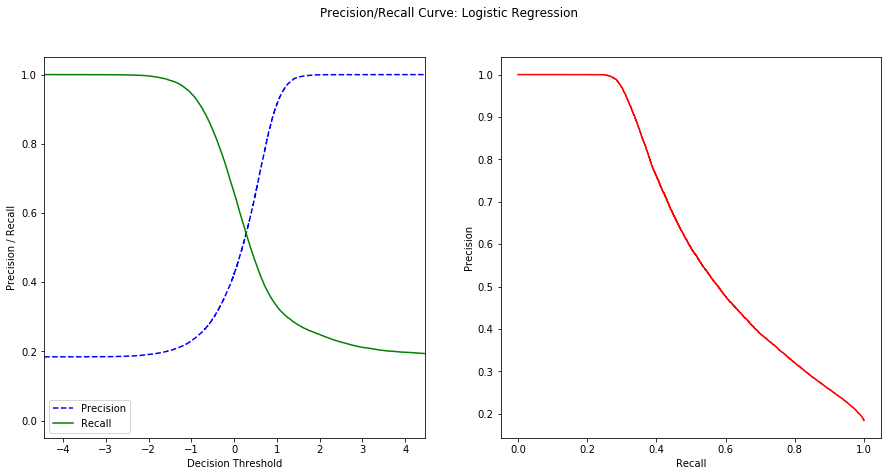

In [379]:
precisions, recalls, thresholds = plot_pr_curve(logreg_best, X_train, y_train, label='Logistic Regression')

In [380]:
# Get threshold value for desired recall
desired_recall = 0.8
i = len(recalls) - np.argmax(recalls[::-1] > desired_recall) - 1
t = thresholds[i]
t

-0.37086149247620764

In [381]:
y_train_pred_t = logreg_best.decision_function(X_train) >= t 

In [382]:
cmat, scores = classifier_summary(y_train, y_train_pred_t)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              104576               63146
Actual Positive                7557               30249
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.461109
Recall       0.800111
Precision    0.323882
Specificity  0.932607
Fallout      0.067393


Reducing the threshold greatly improves recall (selected 80%), however it inevitabely comes at an even greater cost to our precision (32%). Fallout and specificity have further been improved, so if this were used to identify the safest loans for investement (vs. those that will default) we would expect about 93% accuracy.

##### Naive Bayes Classifier

In [62]:
gnb = GaussianNB()

In [64]:
gnb.fit(X_train, y_train)

GaussianNB(priors=None)

In [65]:
train_predict = gnb.predict(X_train)
f1_score(y_train, train_predict)

0.56338217653060074

In [78]:
gnb_cvs = cross_val_score(estimator=gnb, X=X_train, y=y_train, cv=10, scoring='f1', n_jobs=-1)
gnb_cvs.mean()

0.56572450630584459

In [387]:
y_test_pred = gnb.predict(X_test)
y_train_pred = gnb.predict(X_train)

In [388]:
cmat_train, scores_train = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              141457               26265
Actual Positive               12680               25126
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.563382
Recall       0.664604
Precision    0.488918
Specificity  0.917736
Fallout      0.082264


In [389]:
cmat_test, scores_test = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               35343                6620
Actual Positive                3215                6204
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.557838
Recall       0.658669
Precision    0.483780
Specificity  0.916619
Fallout      0.083381


Not a terrible recall score to start considering the previous performance of the logistic regression. Unfortunately, there is nothing in the ways of hyperparameter tuning, so any improvement to this model will require additional feature selection and optimization.

In [ ]:
# Add model to list
model = {'model_name': 'Naive Bayes (Basic)',
         'model_type':'GaussianNB',
         'model': gnb,
         'train_score': train_score,
         'test_score': test_score}

models.append(model)

Will see what additional improvements can be made by modifying the decision boundary:

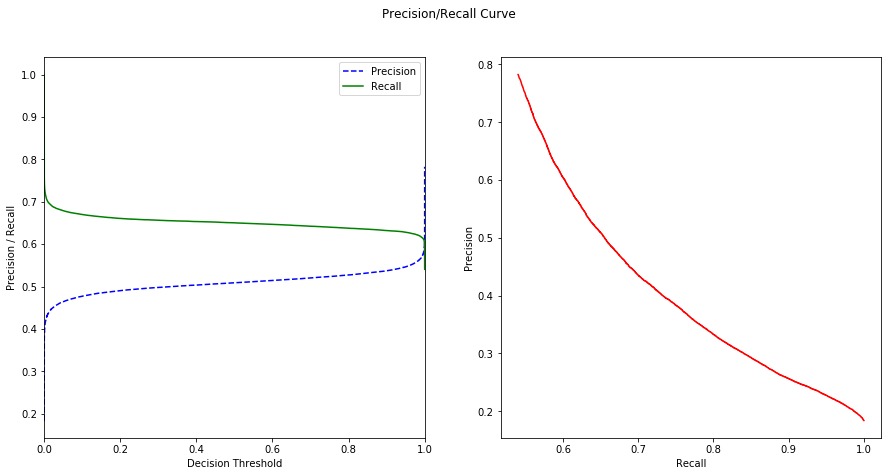

In [390]:
precisions, recalls, thresholds = plot_pr_curve(gnb, X_train, y_train)

In [413]:
# Get threshold value for desired recall
desired_recall = 0.7
i = len(recalls) - np.argmax(recalls[::-1] > desired_recall) - 1
t = thresholds[i]
t

0.0096447936240660684

In [414]:
y_train_pred_t = gnb.predict_proba(X_train)[:,1] >= t 

In [415]:
cmat, scores = classifier_summary(y_train, y_train_pred_t)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              127691               40031
Actual Positive               10242               27564
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.523031
Recall       0.729091
Precision    0.407782
Specificity  0.925747
Fallout      0.074253


Increasing the threshold slightly, we can acheive a recall of 72%, however it comes at the cost of reducing precision to from 48% to 40%. There is also the added benefit of slightly improved specificiy and fallout (on the magnitude of 1-2%)

##### KNN

KNN is not feasible with the number of training instances and features (due to categorical one hot encoding) and the number of records. Will be very slow to both fit and predict ($O(nk+nm)$). Will need to revisit with reduced dimensions, if possible.

##### Support Vector Classifier

Support Vector Classifiers are likely to be computationally expensive due to the number of features, but we will still give it a try and see how it performs.

In [96]:
lin_svc = LinearSVC(dual=False) # n_samples > n_features

In [97]:
lin_svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Quite slow due to large number of training instances n (200k) and features m (100). ($O(m\times n)$)

In [441]:
y_train_pred = lin_svc.predict(X_train)
train_score = f1_score(y_train, y_train_pred)
train_score

0.64666821785899653

In [442]:
y_test_pred = lin_svc.predict(X_test)
test_score = f1_score(y_test, y_test_pred)
test_score

0.64162099798096328

Not a terrible start in f1 score compared to other models thus far, and actually computed faster than anticipated.

In [443]:
# Add model to list
model = {'model_name': 'Linear SVC (Basic)',
         'model_type':'LinearSVC',
         'model': lin_svc,
         'train_score': train_score,
         'test_score': test_score}

models.append(model)

Will see if grid search is feasible for hyperparameter tuning. Note that the grid searches had to be seperated due to incompatibilities between penalty and loss/duality parameters.:

In [112]:
lscv = LinearSVC()

In [116]:
# Grid search w/ l1 penalty
param_grid = {'C': [.001, .01, .1, 1, 10, 100, 1000],
              'penalty': ['l1'],
              'loss': ['squared_hinge'],
              'dual': [False]}

lsvc_l1_gs = GridSearchCV(estimator=lscv,
                       param_grid=param_grid,
                       scoring='f1',
                       cv=3,
                       n_jobs=-1)

lsvc_l1_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1'], 'loss': ['squared_hinge'], 'dual': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [118]:
# Grid search w/ l2 penalty
param_grid = {'C': [.001, .01, .1, 1, 10, 100, 1000],
              'penalty': ['l2'],
              'loss': ['hinge', 'squared_hinge'],
              'dual': [True]}

lsvc_l2_gs = GridSearchCV(estimator=lscv,
                       param_grid=param_grid,
                       scoring='f1',
                       cv=3,
                       n_jobs=-1)

lsvc_l2_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2'], 'loss': ['hinge', 'squared_hinge'], 'dual': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [120]:
lsvc_l1_gs.best_score_, lsvc_l2_gs.best_score_

(0.63358231818054889, 0.65590201874543352)

In [126]:
lsvc_l2_gs.best_params_

{'C': 10, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}

We can see a slight score improvemenet in l2 penalty vs. l1, so we will proceed with the l2 version:

In [132]:
lsvc_best = lsvc_l2_gs.best_estimator_

In [134]:
lsvc_best.set_params(dual=False) # Can switch back to False given l2 & squared_hinge

LinearSVC(C=10, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [135]:
lsvc_best.fit(X_train, y_train)

LinearSVC(C=10, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [417]:
y_train_pred = lsvc_best.predict(X_train)
y_test_pred = lsvc_best.predict(X_test)

In [430]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              167722                   0
Actual Positive               19235               18571
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.658815
Recall       0.491218
Precision    1.000000
Specificity  0.897115
Fallout      0.102885


In [431]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               41963                   0
Actual Positive                4845                4574
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.653755
Recall       0.485614
Precision    1.000000
Specificity  0.896492
Fallout      0.103508


In [439]:
test_scores.iloc[0,0]

0.65375544915314798

Whilst this SVC model has one of the higher f1 scores thus far, and we can see that this model is very strong with precision. Unfortunately this comes at the cost of recall, which is down to just 48%.

In [440]:
# Add model to list
model = {'model_name': 'Linear SVC (Tuned)',
         'model_type':'LinearSVC',
         'model': lsvc_best,
         'train_score': train_scores.iloc[0,0],
         'test_score': test_scores.iloc[0,0]}

models.append(model)

Exploring this tradeoff further may lead to a better model for our purposes (i.e. higher recall vs. precision), with adjustmenets to the decision threshold:

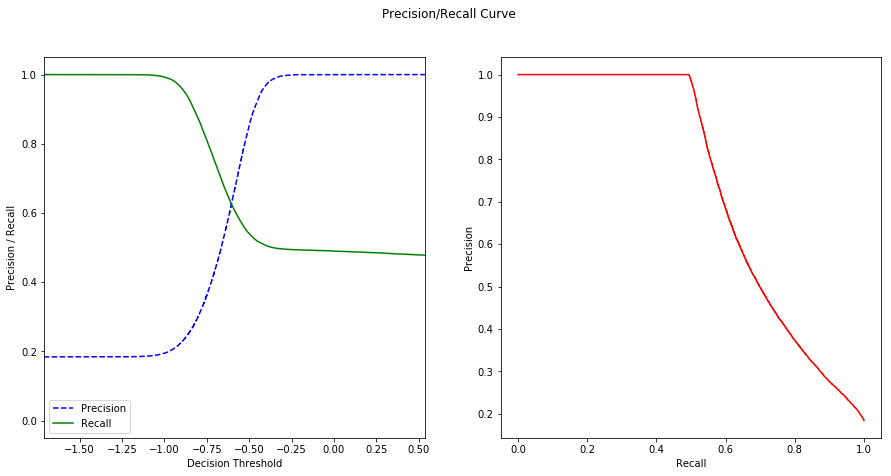

In [422]:
precisions, recalls, thresholds = plot_pr_curve(lsvc_best, X_train, y_train)

In [427]:
# Filter off new threshold
y_train_pred_t = lsvc_best.decision_function(X_train) > -.85

In [428]:
classifier_summary(y_train, y_train_pred_t);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               67036              100686
Actual Positive                2832               34974
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.403238
Recall       0.925091
Precision    0.257806
Specificity  0.959466
Fallout      0.040534


Reducing the threshold greatly improves recall, specificity, and fallout, but again at at a considerable cost to precision.

##### SGD Classifier

In [36]:
sgd = SGDClassifier(max_iter=100, n_jobs=-1)

In [37]:
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [38]:
y_train_pred = sgd.predict(X_train)
y_test_pred = sgd.predict(X_test)

In [39]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              167722                   0
Actual Positive               23277               14529
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.555231
Recall       0.384304
Precision    1.000000
Specificity  0.878130
Fallout      0.121870


In [40]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               41963                   0
Actual Positive                5855                3564
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.549026
Recall       0.378384
Precision    1.000000
Specificity  0.877557
Fallout      0.122443


This untuned model has the worst recall yet, but flawless precision having zero false positives.

In [450]:
# Add model to list
model = {'model_name': 'SGD (Basic)',
         'model_type':'SGDClassifier',
         'model': sgd,
         'train_score': train_scores.iloc[0,0],
         'test_score': test_scores.iloc[0,0]}

models.append(model)

We will see if there are any immediate improvements through parameter tuning:

In [41]:
# Had to reduce variety of params due to computational demand
param_grid = {'loss': ['squared_hinge'],
              'alpha': np.logspace(-6,3,10),
              'penalty':['elasticnet'],
              'l1_ratio':[0.0, 0.5, 1.0],
              'class_weight': ['balanced', None]}

sgd_gs = GridSearchCV(estimator=sgd,
                  param_grid = param_grid,
                  scoring='f1',
                  cv=3,
                  n_jobs=-1)

sgd_gs.fit(X_train, y_train);

In [42]:
sgd_gs.best_params_

{'alpha': 9.9999999999999995e-07,
 'class_weight': None,
 'l1_ratio': 0.5,
 'loss': 'squared_hinge',
 'penalty': 'elasticnet'}

In [43]:
sgd_gs.best_score_

0.58887419287712728

Slight improvement in f1 score over the original model.

In [44]:
sgd_best = sgd_gs.best_estimator_

In [46]:
y_train_pred = sgd_best.predict(X_train)
y_test_pred = sgd_best.predict(X_test)

In [49]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              162621                5101
Actual Positive               17977               19829
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.632141
Recall       0.524493
Precision    0.795387
Specificity  0.900458
Fallout      0.099542


In [50]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               40656                1307
Actual Positive                4521                4898
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.626984
Recall       0.520013
Precision    0.789363
Specificity  0.899927
Fallout      0.100073


Optimizing some of the parameters seems to have at least boosted our recall to around 52%, but this is still worse than our other models thus far. Additionally, the fallout is quite signficant at 10% in comparison to the other models, making this one of the more risk-prone predictors.

In [ ]:
# Add model to list
model = {'model_name': 'SGD Classifier (Tuned)',
         'model_type':'SGDClassifier',
         'model': sgd_best,
         'train_score': train_scores.iloc[0,0],
         'test_score': test_scores.iloc[0,0]}

models.append(model)

##### Decision Tree Classifier

In [51]:
dtc = DecisionTreeClassifier()

In [61]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

In [55]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              167722                   0
Actual Positive                   0               37806
--------------------
Accuracy Scores:
             Score
Rate              
f1             1.0
Recall         1.0
Precision      1.0
Specificity    1.0
Fallout        0.0


In [56]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               37437                4526
Actual Positive                3950                5469
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.563408
Recall       0.580635
Precision    0.547174
Specificity  0.904559
Fallout      0.095441


Here we have a classic example of overfitting. The decision tree clearly needs to be constrained with some of its parameters to limit the depth and number of splits/leaves in the tree.

In [ ]:
# Add model to list
model = {'model_name': 'Decision Tree (Basic)',
         'model_type':'DecisionTreeClassifier',
         'model': dtc,
         'train_score': train_scores.iloc[0,0],
         'test_score': test_scores.iloc[0,0]}

models.append(model)

Due to the variety of parameter values, randomized search will be done in place of grid search:

In [78]:
RandomizedSearchCV?

In [69]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': np.arange(10,100,5),
              'min_samples_split': np.append(np.array([2,3,4]), np.arange(5,101,5)),
              'min_samples_leaf': np.append(np.array([2,3,4]), np.arange(5,101,5)),
              'max_features': np.append(np.array(['sqrt', 'log2', None]), np.arange(0.1,1,0.1)).astype('object')}

dtc_rs = RandomizedSearchCV(estimator=dtc,
                  param_distributions = param_grid,
                  n_iter=100,
                  scoring='f1',
                  cv=3,
                  n_jobs=-1)

dtc_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90,
       95]), 'min_samples_split': array([  2,   3,   4,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,
        55,  60,  65,  70,  75,  80,  85,  90,  95,..., 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
       0.7000000000000001, 0.8, 0.9], dtype=object)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring

In [70]:
dtc_rs.best_params_

{'criterion': 'entropy',
 'max_depth': 55,
 'max_features': 0.7000000000000001,
 'min_samples_leaf': 80,
 'min_samples_split': 20}

In [71]:
dtc_rs.best_score_

0.66669749055934557

In [72]:
dtc_best = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=55,
                                  max_features=0.7,
                                  min_samples_leaf=80,
                                  min_samples_split=20)

In [73]:
dtc_best.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=55,
            max_features=0.7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=80, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [75]:
y_train_pred = dtc_best.predict(X_train)
y_test_pred = dtc_best.predict(X_test)

In [76]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              167589                 133
Actual Positive               18804               19002
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.667428
Recall       0.502619
Precision    0.993049
Specificity  0.899116
Fallout      0.100884


In [77]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               41921                  42
Actual Positive                4733                4686
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.662473
Recall       0.497505
Precision    0.991117
Specificity  0.898551
Fallout      0.101449


Although our parameter tuning improved overall f1 scores, it actually wound up hurting our recall, specificity, and fallout in order to acheive higher precision, which is the score we are least concerned with. We will try optimizing parameters with respect to the recall score:

In [79]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': np.arange(10,100,5),
              'min_samples_split': np.append(np.array([2,3,4]), np.arange(5,101,5)),
              'min_samples_leaf': np.append(np.array([2,3,4]), np.arange(5,101,5)),
              'max_features': np.append(np.array(['sqrt', 'log2', None]), np.arange(0.1,1,0.1)).astype('object')}

dtc_rs_2 = RandomizedSearchCV(estimator=dtc,
                  param_distributions = param_grid,
                  n_iter=100,
                  scoring='recall',
                  cv=3,
                  n_jobs=-1)

dtc_rs_2.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90,
       95]), 'min_samples_split': array([  2,   3,   4,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,
        55,  60,  65,  70,  75,  80,  85,  90,  95,..., 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
       0.7000000000000001, 0.8, 0.9], dtype=object)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring

In [80]:
dtc_rs_2.best_params_

{'criterion': 'entropy',
 'max_depth': 60,
 'max_features': 0.8,
 'min_samples_leaf': 5,
 'min_samples_split': 15}

In [81]:
dtc_rs_2.best_score_

0.56800507971723146

In [102]:
dtc_best = dtc_rs_2.best_estimator_

In [103]:
dtc_best.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=60,
            max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=15,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [104]:
y_train_pred = dtc_best.predict(X_train)
y_test_pred = dtc_best.predict(X_test)

In [105]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              163673                4049
Actual Positive                8725               29081
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.819922
Recall       0.769217
Precision    0.877784
Specificity  0.949390
Fallout      0.050610


In [106]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               38937                3026
Actual Positive                4130                5289
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.596481
Recall       0.561525
Precision    0.636079
Specificity  0.904103
Fallout      0.095897


Whilst there is some improvement in recall, it seems that this model still suffers from overfitting when trying to maximize recall. Acheiving a better balance between overfitting and recall will likely require more extensive parameter tweaking and feature optimization beyond the scope of this MVP. For the sake of this analysis, perhaps a random forest classifier will provide a more immediate improvement.

##### Random Forest Classifier

In [107]:
rfc = RandomForestClassifier(n_estimators=20,
                             criterion='entropy',
                             max_features=0.8,
                             max_depth=60,
                             min_samples_split=5,
                             min_samples_leaf=15,
                             n_jobs=-1)

In [108]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=60, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [109]:
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

In [110]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              167710                  12
Actual Positive               18456               19350
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.676952
Recall       0.511824
Precision    0.999380
Specificity  0.900863
Fallout      0.099137


In [111]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               41934                  29
Actual Positive                4749                4670
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.661567
Recall       0.495806
Precision    0.993828
Specificity  0.898271
Fallout      0.101729


In [112]:
param_grid = {'bootstrap': [True, False],
              'criterion': ['gini', 'entropy'],
              'class_weight': ['balanced', None],
              'max_features': np.arange(.5,.91,0.1),
              'max_depth': np.arange(20,60,5),
              'min_samples_split': np.arange(20,101,5),
              'min_samples_leaf': np.arange(50,101,5)}

rfc_rs = RandomizedSearchCV(estimator=rfc,
                  param_distributions = param_grid,
                  n_iter=50,
                  scoring='recall',
                  cv=3,
                  n_jobs=-1)

rfc_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=60, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced', None], 'max_features': array([ 0.5 ,  0.51,  0.52,  0.53,  0.54,  0.55,  0.56,  0.57,  0.58,
        0.59,  0.6 ,  0.61,  0.62,  0.63,  0.64,  0.65,  0.66,  0.67,
        0.68,  0.69,  0.7... 90,  95, 100]), 'min_samples_leaf': array([ 50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100])},
          pre_dispatch='2*n_jobs', ran

In [113]:
rfc_rs.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 27,
 'max_features': 0.96000000000000041,
 'min_samples_leaf': 90,
 'min_samples_split': 40}

In [114]:
rfc_rs.best_score_

0.65225099106591289

In [131]:
rfc_best = RandomForestClassifier(n_estimators=20,
                                  bootstrap=False,
                                  class_weight='balanced',
                                  criterion='entropy',
                                  max_depth=25,
                                  max_features=0.9,
                                  min_samples_leaf=90,
                                  min_samples_split=40,
                                  n_jobs=-1)

In [132]:
rfc_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='entropy', max_depth=25, max_features=0.9,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=90,
            min_samples_split=40, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [133]:
y_train_pred = rfc_best.predict(X_train)
y_test_pred = rfc_best.predict(X_test)

In [134]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              152386               15336
Actual Positive               10557               27249
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.677912
Recall       0.720759
Precision    0.639873
Specificity  0.935210
Fallout      0.064790


In [135]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               37587                4376
Actual Positive                3375                6044
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.609305
Recall       0.641682
Precision    0.580038
Specificity  0.917607
Fallout      0.082393
